# Code pour exporter les données sous tableau numpy organisés par dossiers

# Les imports & le code de base Mediapipe

In [3]:
import mediapipe as mp  # Import mediapipe
import cv2  # Import opencv
import csv
import os
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
import sklearn

mp_drawing = mp.solutions.drawing_utils  # Drawing helpers
mp_holistic = mp.solutions.holistic  # Mediapipe Solutions

# Préliminaires

Fonctions pour rendre le code plus lisible

In [4]:
def mediapipe_detection(image, model): #Fonction pour que mediapipe puisse détecter (car il ne travaille pas dans le même système de couleur que OpenCV)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# Extraire nos données

Fonction préliminaire pour faciliter la lecture du code

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    #return np.concatenate([pose, face, lh, rh])
    return np.concatenate([pose, lh, rh])

Choix des paramètres

In [6]:
path = 'datas_mots/' #path vers le dossier des mots
data_path = os.path.join('donnees_export_v2') 
mots=np.array(['adresse','affaire']) #choix des mots
nb_videos=20 #nb de vidéos par mot
nb_frame=20 #nombre d'images par vidéos

Prélis pour parcourir notre jeu de données

In [7]:
fichier =list([])
for mot in mots:
    fichier1=[]
    i=0
    for f in os.listdir(path):
        if i<nb_videos:
            file_name, file_ext = os.path.splitext(f)
            testmot = file_name.split('-')
            if (testmot[0]==mot):
                fichier1 += [path + file_name + file_ext]
                i+=1
    fichier.append(fichier1)
print(fichier)

[['../mots/adresse-05.mp4', '../mots/adresse-13.mp4', '../mots/adresse-07.mp4', '../mots/adresse-10.mp4', '../mots/adresse-15.mp4', '../mots/adresse-18.mp4', '../mots/adresse-14.mp4', '../mots/adresse-01.mp4', '../mots/adresse-03.mp4', '../mots/adresse-06.mp4', '../mots/adresse-09.mp4', '../mots/adresse-12.mp4', '../mots/adresse-00.mp4', '../mots/adresse-11.mp4', '../mots/adresse-17.mp4'], ['../mots/affaire-09.mp4', '../mots/affaire-11.mp4', '../mots/affaire-14.mp4', '../mots/affaire-08.mp4', '../mots/affaire-15.mp4', '../mots/affaire-04.mp4', '../mots/affaire-18.mp4', '../mots/affaire-01.mp4', '../mots/affaire-19.mp4', '../mots/affaire-12.mp4', '../mots/affaire-02.mp4', '../mots/affaire-03.mp4', '../mots/affaire-10.mp4', '../mots/affaire-13.mp4', '../mots/affaire-07.mp4']]


Préparer le dossier pour le stockage des données

In [8]:
for mot in mots: 
    for vid in range(nb_videos):
        try: 
            os.makedirs(os.path.join(data_path, mot, str(vid)))
        except:
            pass

Stocker les données

In [ ]:
rang_mot = 0
rang_video = 0
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for mot in mots:
        #print(mot)
        for f in fichier[rang_mot]:
            #print(f)
            cap = cv2.VideoCapture(f)
            for frame_num in range(nb_frame):
                ret, frame = cap.read()
                if ret :
                    image, results = mediapipe_detection(frame, holistic)

                    draw_styled_landmarks(image, results)

                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(data_path, mot, str(rang_video), str(frame_num))
                    np.save(npy_path, keypoints)

                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break
                else :
                    break
            rang_video+=1
            cap.release()
            cv2.destroyAllWindows()
        rang_video=0
        rang_mot+=1            

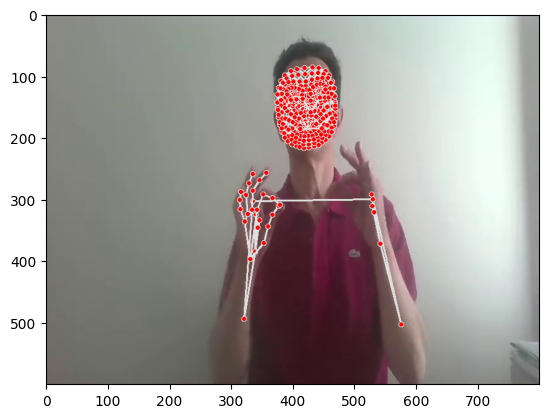

In [32]:
draw_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Traitement des données

In [9]:
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils import to_categorical

Pour l'instant on essaye avec les données brutes, à voir comment on les traitera dans le futur

In [10]:
label_map = {label:num for num, label in enumerate(mots)}
print(label_map)
videos, labels = [], []
for mot in mots:
    # print(mot)
    # print(label_map[mot])
    for video in range(nb_videos):
        vid = []
        for frame_num in range(nb_frame):
            image = np.load(os.path.join(data_path, mot, str(video), "{}.npy".format(frame_num)))
            vid.append(image)
        videos.append(vid)
        labels.append(label_map[mot])

X = np.array(videos)

{'adresse': 0, 'affaire': 1}


# Entrainement du modèle

In [11]:
X = np.array(videos)
#y = to_categorical(labels).astype(int)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)